# Importamos y Cogemos Material Necesario

Librerías

In [1]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

Cogemos Imágenes de Perros y Gatos

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2022-10-25 17:27:25--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2607:f8b0:400a:804::2010, 2607:f8b0:400a:80a::2010, 2607:f8b0:400a:806::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2607:f8b0:400a:804::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  21.1MB/s    in 3.2s    

2022-10-25 17:27:28 (20.3 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



Creamos los directorios de perros y gatos

In [3]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Importamos el modelo InceptionV3

In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


Hacemos uso de todas las capas del modelo excepto la última capa densa (totalmente conectada)

In [5]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-10-25 17:27:29.542195: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-25 17:27:29.542341: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Hacemos que las capas no sean entrenables (podemos dejar alguna más para entrenar nosotros, pero tenemos que tener cuidado con el overfitting)



In [6]:
for layer in pre_trained_model.layers:
  layer.trainable = False

Vemos la red que tenemos

In [7]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

# Entrenamos el modelo

Definimos un callback si el accuracy supera el 95%

In [8]:

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

# Entrenamos la red

In [9]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(learning_rate=0.0001),  #Usamos RMSprop para el learningrate: tambien podemos usar Adam o Adagrad
              loss = 'binary_crossentropy',  #Usamnos binary_crossentropy porque tenemos 2 clases a predecir (perros y gatos)
              metrics = ['acc'])

Hacemos data augmentation

In [10]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Entrenamos la red

In [11]:

callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_steps = 50,
            verbose = 2,
            callbacks=[callbacks])

Epoch 1/100


2022-10-25 17:27:32.037721: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-25 17:27:33.861819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-25 17:27:42.117016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 - 12s - loss: 1.1827 - acc: 0.8480 - val_loss: 0.1942 - val_acc: 0.9530 - 12s/epoch - 123ms/step
Epoch 2/100
100/100 - 8s - loss: 0.3877 - acc: 0.8985 - val_loss: 0.1418 - val_acc: 0.9590 - 8s/epoch - 84ms/step
Epoch 3/100
100/100 - 8s - loss: 0.4050 - acc: 0.9030 - val_loss: 0.3646 - val_acc: 0.9220 - 8s/epoch - 82ms/step
Epoch 4/100
100/100 - 8s - loss: 0.3371 - acc: 0.9110 - val_loss: 0.1333 - val_acc: 0.9650 - 8s/epoch - 83ms/step
Epoch 5/100
100/100 - 8s - loss: 0.3343 - acc: 0.9120 - val_loss: 0.1341 - val_acc: 0.9610 - 8s/epoch - 83ms/step
Epoch 6/100
100/100 - 8s - loss: 0.3067 - acc: 0.9235 - val_loss: 0.1449 - val_acc: 0.9640 - 8s/epoch - 82ms/step
Epoch 7/100
100/100 - 8s - loss: 0.3489 - acc: 0.9115 - val_loss: 0.1219 - val_acc: 0.9620 - 8s/epoch - 83ms/step
Epoch 8/100
100/100 - 8s - loss: 0.3045 - acc: 0.9235 - val_loss: 0.1466 - val_acc: 0.9550 - 8s/epoch - 83ms/step
Epoch 9/100
100/100 - 8s - loss: 0.2906 - acc: 0.9180 - val_loss: 0.3356 - val_acc: 0.9350 - 8s/e

Dibujamos las métricas relevantes

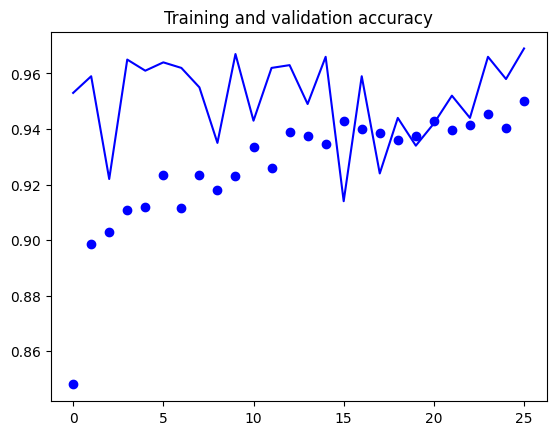

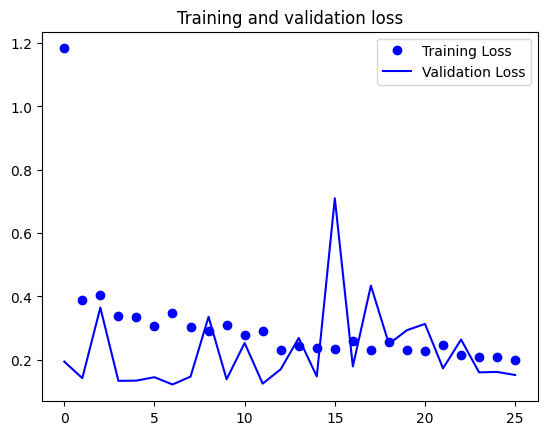

In [12]:

import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Uso del modelo para predecir imágenes

In [39]:
import numpy as np
import tkinter as tk
from tkinter import filedialog
from keras.preprocessing import image


root = tk.Tk()
root.withdraw()

file_path = filedialog.askopenfilename()
path = file_path
img = tf.keras.utils.load_img(path, target_size=(150, 150))
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
if classes <0.5 :
    labels = 0
else: 
    labels = 1



print(labels)
print(classes)

print(file_path)


2022-10-25 17:48:33.978 python[4447:35183] +[CATransaction synchronize] called within transaction
2022-10-25 17:48:33.983 python[4447:35183] +[CATransaction synchronize] called within transaction
2022-10-25 17:48:38.849 python[4447:35183] +[CATransaction synchronize] called within transaction


1/1 [==============================] - 0s 36ms/step
1
[[1.]]
/Users/danielrangel/Downloads/dog.22.jpg
